In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from torchvision.models import *
import yaml
import pandas as pd
import datetime

from sklearn.metrics import roc_auc_score

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cp -f /gdrive/My\ Drive/Colab-Notebooks/fastai/colab.zip .

In [0]:
# !wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

In [0]:
from pathlib import Path
import shutil
import zipfile
import yaml

In [0]:
zip = zipfile.ZipFile('./colab.zip')
zip.extractall('./data')
zip.close()

 **Load configuration with local path and url for dataset**

In [0]:
data_path = './data'

**Load Data**

In [0]:
full_train_df = pd.read_csv('./data/colab/train.csv')
full_valid_df = pd.read_csv('./data/colab/valid.csv')

In [102]:
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [103]:
full_valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64541,study1
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64542,study1
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64542,study1
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64543,study1
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64544,study1


In [0]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

**Uncertainty Approaches**

The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:



*   Ignoring - essentially removing from the calculation in the loss function
*   Binary mapping - sending uncertain values to either 0 or 1
*   Prevalence mapping - use the rate of prevelance of the feature as it's target value
*   Self-training - consider the uncertain values as unlabeled
*   3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its          own right


The paper gives the results of different experiments with the above approaches and indicates the most accurate approach for each feature.



Approach/Feature    Atelectasis	   Cardiomegaly	   Consolidation	   Edema	   PleuralEffusion

U-Ignore	0.818(0.759,0.877)	0.828(0.769,0.888)	0.938(0.905,0.970)	0.934(0.893,0.975)
0.928(0.894,0.962)

U-Zeros	            0.811(0.751,0.872)	0.840(0.783,0.897)	0.932(0.898,0.966)	0.929(0.888,0.970)	0.931(0.897,0.965)

U-Ones	0.858(0.806,0.910)	0.832(0.773,0.890)	0.899(0.854,0.944)	0.941(0.903,0.980)	0.934(0.901,0.967)

U-Mean	0.821(0.762,0.879)	0.832(0.771,0.892)	0.937(0.905,0.969)	0.939(0.902,0.975)	0.930(0.896,0.965)

U-SelfTrained	0.833(0.776,0.890)	0.831(0.770,0.891)	0.939(0.908,0.971)	0.935(0.896,0.974)	0.932(0.899,0.966)

U-MultiClass	0.821(0.763,0.879)	0.854(0.800,0.909)	0.937(0.905,0.969)	0.928(0.887,0.968)	0.936(0.904,0.967)


The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature

*   Atelectasis U-Ones
*   Cardiomegaly U-Zeros
*  Consolidation U-Zeros
*   Edema U-Ones
*   Pleural Effusion U-Zeros

In [0]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

In [0]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [0]:
full_train_df['train_valid'] = False
full_valid_df['train_valid'] = True

**Create patient and study columns**

In [0]:
full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

In [109]:
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1


In [0]:
full_df = pd.concat([full_train_df, full_valid_df])

In [0]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [112]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1,
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2,Atelectasis;Edema
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,Edema


**Set up data set using Fastai datablock**

In [0]:
def get_src(df = full_df):
    return (ImageList
        .from_df(df, data_path, 'Path')
        .split_from_df('train_valid')
        .label_from_df('feature_string',label_delim=';')
       )

def get_data(size, src, bs=32):
    return (src.transform(get_transforms(do_flip=False), size=size, padding_mode='zeros')
        .databunch(bs=bs).normalize(imagenet_stats))

In [0]:

# x = ImageList.from_df(full_df, data_path, 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [0]:
# x.transform(get_transforms(do_flip=False), size=224, padding_mode='zeros').databunch(bs=34).normalize(imagenet_stats)

**Create a function to evaluate performance of all features**

In [0]:
def validation_eval(learn):
    acts = full_valid_df.groupby(['patient','study'])[learn.data.classes].max().values

    valid_preds=learn.get_preds(ds_type=DatasetType.Valid)
    preds = valid_preds[0]
    preds_df = full_valid_df.copy()
    
    print(len(full_valid_df), len(preds))
    for i, c in enumerate(learn.data.classes):
        preds_df[c] = preds[:,i]

    preds = preds_df.groupby(['patient','study'])[learn.data.classes].mean().values

    auc_scores = {learn.data.classes[i]: roc_auc_score(acts[:,i],preds[:,i]) for i in range(len(chexpert_targets))}

    #average results reported in the associated paper
    chexpert_auc_scores = {'Atelectasis':      0.858,
                           'Cardiomegaly':     0.854,
                           'Consolidation':    0.939,
                           'Edema':            0.941,
                           'Pleural Effusion': 0.936}

    max_feat_len = max(map(len, chexpert_targets))

    avg_chexpert_auc = sum(list(chexpert_auc_scores.values()))/len(chexpert_auc_scores.values())
    avg_auc          = sum(list(auc_scores.values()))/len(auc_scores.values())

    [print(f'{k: <{max_feat_len}}\t auc: {auc_scores[k]:.3}\t chexpert auc: {chexpert_auc_scores[k]:.3}\t difference:\
    {(chexpert_auc_scores[k]-auc_scores[k]):.3}') for k in chexpert_targets]

    print(f'\nAverage auc: {avg_auc:.3} \t CheXpert average auc {avg_chexpert_auc:.3}\t Difference {(avg_chexpert_auc-avg_auc):.3}')

def avg_auc_metric(input, targs):
    input=input.detach().cpu()
    targs=targs.detach().cpu().byte()
    auc_scores = [roc_auc_score(targs[:,i],input[:,i]) for i in range(targs.shape[1])]
    auc_scores = torch.tensor(auc_scores)
    return auc_scores.mean()

**Create callbacks to evaluate and save learner**

In [0]:
class SaveCallback(LearnerCallback):
    _order = 99
    def __init__(self, learn):
        super().__init__(learn)
        self.epoch = 0
        self.skip = False
    def on_epoch_end(self, **kwargs):
        self.epoch += 1
        if self.skip: return
        learn.save(f'{datetime.datetime.now():%Y-%m-%d %H:%M}')


In [0]:

def get_chexpert_learner(learn=None, img_size=320, size=1, mixup=True, pretrained=True, callback_fns=[]):
    bs = 256
    data = get_data(img_size, get_src(full_df(size)), bs=bs)
    learn = cnn_learner(data, models.densenet121, callback_fns=callback_fns, pretrained=pretrained, metrics=avg_auc_metric).mixup(stack_y=False)
    return learn

**Alter LR_Finder to remove my callbacks before running**

In [0]:
cbfs = [SaveCallback]
def lr_find_no_cbs(learn):
    learn.callback_fns = [cbf for cbf in learn.callback_fns if cbf not in cbfs]
    lr_find(learn)
    learn.recorder.plot(suggestion=True)
    learn.callback_fns += cbfs

In [0]:
# ls

In [121]:
mv colab CheXpert-v1.0-small

mv: cannot stat 'colab': No such file or directory


In [122]:
pwd

'/content'

In [126]:
# cd content

/content


In [0]:
df_names = os.listdir('./data/CheXpert-v1.0-small/train/')

In [0]:
names_fulldf = [('').join(item.split('/')[-3:]) for item in full_df['Path'].tolist()]

In [75]:
full_valid_df['Path'][:5]

0    CheXpert-v1.0-small/valid/patient64541/study1/...
1    CheXpert-v1.0-small/valid/patient64542/study1/...
2    CheXpert-v1.0-small/valid/patient64542/study1/...
3    CheXpert-v1.0-small/valid/patient64543/study1/...
4    CheXpert-v1.0-small/valid/patient64544/study1/...
Name: Path, dtype: object

In [0]:
# val_df = os.listdir('./data/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg')

In [0]:
# val_df[:5]

In [0]:
# names_valdf = [('').join(item.split('/')[-3:4]) for item in full_valid_df['Path'].tolist()]

In [0]:
# names_valdf[:5]

In [0]:
ls=[]
for item in df_names:
  if item in names_fulldf:
    ls.append(names_fulldf.index(item))

In [50]:
df_names[:10]

['patient01545study6view1_frontal.jpg',
 'patient00343study1view1_frontal.jpg',
 'patient02279study1view1_frontal.jpg',
 'patient00408study4view1_frontal.jpg',
 'patient01172study1view1_frontal.jpg',
 'patient01247study6view2_lateral.jpg',
 'patient00179study1view1_frontal.jpg',
 'patient01071study24view1_frontal.jpg',
 'patient02129study4view1_frontal.jpg',
 'patient02476study12view1_frontal.jpg']

In [0]:
names_ = ['CheXpert-v1.0-small/train/'+name for name in df_names]

In [0]:
full_df = full_df.iloc[ls]

In [0]:
full_df['Path'] = names_

In [55]:
full_df['Path'].tolist()[:10]

['CheXpert-v1.0-small/train/patient01545study6view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient00343study1view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient02279study1view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient00408study4view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient01172study1view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient01247study6view2_lateral.jpg',
 'CheXpert-v1.0-small/train/patient00179study1view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient01071study24view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient02129study4view1_frontal.jpg',
 'CheXpert-v1.0-small/train/patient02476study12view1_frontal.jpg']

In [133]:
full_df['train_valid'].unique()

array([False])

In [0]:
full_df = pd.concat([full_df, full_valid_df])

In [0]:
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

**Train on sample set on small images**

In [0]:
img_size = 64
data = get_data(img_size, get_src(full_df), bs=40)
learn = cnn_learner(data, models.vgg16_bn, callback_fns=cbfs)

In [0]:
# learn.summary()

In [150]:
lr = 1e-5
learn.fit_one_cycle(1,slice(lr))

epoch,train_loss,valid_loss,time
0,0.820675,0.753742,00:39


In [151]:
validation_eval(learn)

234 234
Atelectasis     	 auc: 0.466	 chexpert auc: 0.858	 difference:    0.392
Cardiomegaly    	 auc: 0.426	 chexpert auc: 0.854	 difference:    0.428
Consolidation   	 auc: 0.406	 chexpert auc: 0.939	 difference:    0.533
Edema           	 auc: 0.617	 chexpert auc: 0.941	 difference:    0.324
Pleural Effusion	 auc: 0.477	 chexpert auc: 0.936	 difference:    0.459

Average auc: 0.479 	 CheXpert average auc 0.906	 Difference 0.427


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


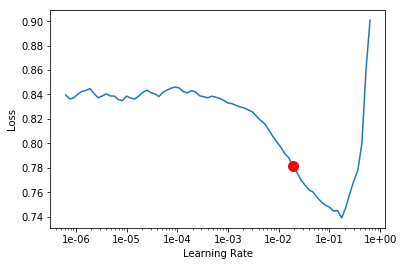

In [168]:
lr_find_no_cbs(learn)

In [0]:
# learn = get_chexpert_learner(learn=learn, img_size=128, size=1)
# lr_find_no_cbs(learn)

In [170]:
lr = 1.91E-02
learn.fit_one_cycle(10,slice(lr))

epoch,train_loss,valid_loss,time
0,0.490752,0.536411,00:41
1,0.473616,0.524947,00:41
2,0.452512,0.530567,00:41
3,0.439171,0.528451,00:40
4,0.433088,0.524311,00:40
5,0.427607,0.475714,00:40
6,0.416479,0.475797,00:40
7,0.411647,0.473525,00:40
8,0.401732,0.466118,00:40
9,0.398893,0.469247,00:41


In [171]:
validation_eval(learn)

234 234
Atelectasis     	 auc: 0.787	 chexpert auc: 0.858	 difference:    0.0706
Cardiomegaly    	 auc: 0.758	 chexpert auc: 0.854	 difference:    0.0962
Consolidation   	 auc: 0.877	 chexpert auc: 0.939	 difference:    0.0623
Edema           	 auc: 0.859	 chexpert auc: 0.941	 difference:    0.0816
Pleural Effusion	 auc: 0.852	 chexpert auc: 0.936	 difference:    0.0844

Average auc: 0.827 	 CheXpert average auc 0.906	 Difference 0.079


In [0]:
lr_find_no_cbs(learn)

**Things to try to improve score**

Building more sophisticated model structure to account for unknowns

Curriculum learning

Mixup

(not really possible) Use the labelling tool from the ChexPert paper : https://github.com/stanfordmlgroup/chexpert-labeler
\